# CEIA - Análisis de Datos
## Trabajo Práctico Número 2

### Grupo: 

          - Martín A. Brocca 
          - Agustín A. Lopez Fredes 

Dataset seleccionado: [AirBnB Dataset](https://insideairbnb.com/get-the-data/)

In [126]:
# importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point
import missingno as msno



#### De acuerdo a lo realizado en el TP1, el problema seleccionado cuenta con un dataset conformado por 7 archivos:
| **Archivo**                | **Descripción**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Listing.csv.gz         | Listado detallado de inmuebles                                               |
| Calendar.csv.gz        | Información detallada de fechas de reserva y ocupación                       |
| Reviews.csv.gz         | Listado detallado de opiniones y valoraciones de usuarios                    |
| Listing.csv            | Versión resumida del listado de inmuebles para facilitar visualizaciones     |
| Neighbourhoods.csv     | Listado de barrios de la localidad                                           |
| Neighbourhoods.geojson | Archivo GeoJson con los barrios de la localidad                              |


El dataset corresponde a los últimos 12 meses a cierre de Enero 2025

Se utilizarán los archivos detallados para el EDA, como así también el archivo geojson para la representación gráfica de algunas conclusiones o reportes.


In [127]:
#  URL para descargar todos los archivos que conforman el dataset
data_base_url = "https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2025-01-29"


# Definimos los nombres de los archivos y sus correspondientes URLs
data_files = {
    "df_listings_details": "/data/listings.csv.gz",
    "df_reviews_details": "/data/reviews.csv.gz",
    "df_calendar": "/data/calendar.csv.gz",
    "df_listings": "/visualisations/listings.csv",
    "df_reviews": "/visualisations/reviews.csv",
    "df_neighbourhoods": "/visualisations/neighbourhoods.csv",
}


# Carga directa de los archivos CSV desde la URL
dfs = {
    #name: pd.read_csv(base_url + filename, compression="gzip" if filename.endswith(".gz") else None)
    name: pd.read_csv(data_base_url + filename)
    for name, filename in data_files.items()
}
# Carga del archivo GeoJSON
dfs["df_neighbourhoods_geojson"] = gpd.read_file(
    data_base_url + "/visualisations/neighbourhoods.geojson"
)


In [128]:
# Creación de las variables individuales.
df_listings_details = dfs["df_listings_details"]
#df_neighborhoods = dfs["df_neighbourhoods"]
#df_reviews_details = dfs["df_reviews_details"]
#df_calendar = dfs["df_calendar"]

In [129]:
# Convertimos el precio en float, limpiando los caracteres previamente
# Elimina símbolo de dólar, comas y espacios, luego convierte a float
df_listings_details['price'] = (
    df_listings_details['price']
    .replace('[\$,]', '', regex=True)  # quita $ y ,
    .astype(float)
)

Debido a que el dataset de listings cuenta con 45 columnas, en el TP1 determinamos aquellas de interés:

In [130]:
df_listings_details_interes = df_listings_details[['id','property_type', 'room_type', 
                                           'name', 'description','accommodates', 'bedrooms', 'beds', 
                                            'bathrooms','price', 'availability_eoy',
                                            'estimated_occupancy_l365d', 'review_scores_rating',
                                            'review_scores_accuracy', 'review_scores_cleanliness',                                                     'review_scores_checkin', 'review_scores_communication',
                                            'review_scores_location','latitude', 'longitude', 
                                            'review_scores_value','number_of_reviews','reviews_per_month', 
                                            'neighbourhood', 'neighbourhood_cleansed',
                                            'host_identity_verified', 'host_has_profile_pic']]

Queremos predecir el nivel de ocupación que tendrá cada propiedad, por lo que el target será el nivel de disponibilidad anual de los listings ('availability_eoy'). Esta variable muestra la cantidad de días que una propiedad estuvo disponible en el año, por lo que es el complemento de la ocupación. 

En el TP1 se analizaron los valores faltantes y outliers. Repasamos las cantidades para determinar si se eliminan las filas/columnas o se imputan:

In [131]:
# Función para informar las columnas con mayor cantidad de datos faltantes orderadas de mayor a menor
def report_missing(df):
    missing_report = (
        df.isnull().sum()
        .to_frame(name='missing_count')
        .assign(missing_pct=lambda x: (x['missing_count'] / len(df)) * 100)
        .sort_values(by='missing_count', ascending=False)
    )
    return missing_report

In [132]:
# Función auxiliar para detectar outliers
def detectar_outliers(df):
    # Seleccionar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in columnas_numericas:
        # Calcular IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Límites para IQR con umbral 1.5
        limite_inferior_iqr_1_5 = Q1 - 1.5 * IQR
        limite_superior_iqr_1_5 = Q3 + 1.5 * IQR
        
        # Límites para IQR con umbral 3 (outliers severos)
        limite_inferior_iqr_3 = Q1 - 3 * IQR
        limite_superior_iqr_3 = Q3 + 3 * IQR

        # Calcular media y desviación estándar (umbral fijo de 3)
        mean = df[col].mean()
        std = df[col].std()
        limite_inferior_std = mean - 3 * std
        limite_superior_std = mean + 3 * std

        # Identificar outliers
        outliers_iqr_1_5 = df[(df[col] < limite_inferior_iqr_1_5) | (df[col] > limite_superior_iqr_1_5)]
        outliers_iqr_3 = df[(df[col] < limite_inferior_iqr_3) | (df[col] > limite_superior_iqr_3)]
        outliers_std = df[(df[col] < limite_inferior_std) | (df[col] > limite_superior_std)]

        # Calcular porcentajes
        total_data_points = len(df[col].dropna())
        outlier_percentage_iqr_1_5 = (len(outliers_iqr_1_5) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_iqr_3 = (len(outliers_iqr_3) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_std = (len(outliers_std) / total_data_points) * 100 if total_data_points > 0 else 0

        # Guardar resultados
        results.append({
            'Columna': col,
            'Porcentaje Outliers (Umbral 1.5 * IQR)': round(outlier_percentage_iqr_1_5, 2),
            'Porcentaje Outliers Severos (Umbral 3 * IQR)': round(outlier_percentage_iqr_3, 2),
            'Porcentaje Outliers (Umbral 3 * STD)': round(outlier_percentage_std, 2)
        })

    # Convertir resultados a DataFrame
    result_df = pd.DataFrame(results)
    
    # Ordenar por porcentaje de outliers (Umbral 1.5 * IQR) de mayor a menor
    result_df_sorted = result_df.sort_values(by='Porcentaje Outliers Severos (Umbral 3 * IQR)', ascending=False)
    
    # Generar gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=result_df_sorted,
        x='Columna',
        y='Porcentaje Outliers Severos (Umbral 3 * IQR)',
        color='#4e79a7'  # Azul oscuro compatible con temas claros y oscuros
    )
    plt.title('Porcentaje de Outliers por Columna (Umbral 3 * IQR)')
    plt.xlabel('Columnas')
    plt.ylabel('Porcentaje de Outliers (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return result_df

#### Valores faltantes
##### Listings

In [133]:
report_missing(df_listings_details_interes)

,missing_count,missing_pct
neighbourhood,18584,52.837484
review_scores_accuracy,5761,16.379506
review_scores_value,5761,16.379506
review_scores_checkin,5760,16.376663
reviews_per_month,5760,16.376663
review_scores_location,5760,16.376663
review_scores_rating,5760,16.376663
review_scores_communication,5760,16.376663
review_scores_cleanliness,5760,16.376663
price,3574,10.161492


- Para 'neighbourhood', observamos que la podemos reemplazar variable 'neighbourhood_cleansed' que no tiene faltantes, por lo que la eliminamos. 
- 'description' es una variable de texto que no se utilizará para el modelado, por lo que se elimina también
- 'host_has_profile_pic' y 'host_identity_verified' sólo tienen 6 valores faltantes, por lo que podemos eliminar las filas
- Para el resto haremos imputaciones (previo split train/test) 

In [134]:
print(f"Shape original de dataset:{df_listings_details_interes.shape}")
df_listings_details_interes.drop(columns=['id','neighbourhood', 'description'], inplace=True)
df_listings_details_interes.dropna(subset=['host_has_profile_pic', 'host_identity_verified'], inplace=True)
print(f"Shape resultante:{df_listings_details_interes.shape}")

Shape original de dataset:(35172, 27)
Shape resultante:(35166, 24)


C:\Users\alope\AppData\Local\Temp\ipykernel_25528\3972544994.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes.drop(columns=['id','neighbourhood', 'description'], inplace=True)
C:\Users\alope\AppData\Local\Temp\ipykernel_25528\3972544994.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes.dropna(subset=['host_has_profile_pic', 'host_identity_verified'], inplace=True)


#### Outliers
##### Listings

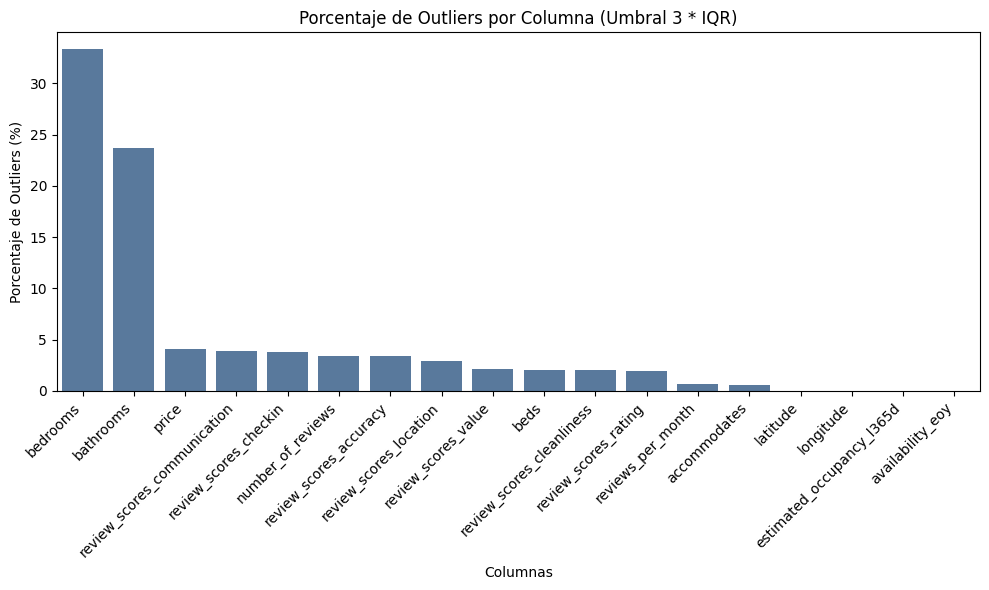

,Columna,Porcentaje Outliers (Umbral 1.5 * IQR),Porcentaje Outliers Severos (Umbral 3 * IQR),Porcentaje Outliers (Umbral 3 * STD)
0,accommodates,1.58,0.55,1.58
1,bedrooms,33.31,33.31,0.84
2,beds,9.74,2.05,1.20
3,bathrooms,23.73,23.73,1.47
4,price,8.52,4.09,0.11
5,availability_eoy,0.00,0.00,0.00
6,estimated_occupancy_l365d,5.62,0.00,0.00
7,review_scores_rating,5.68,1.92,1.66
8,review_scores_accuracy,6.26,3.37,1.61
9,review_scores_cleanliness,6.04,2.04,1.74


In [135]:
porcentaje_outliers_listings = detectar_outliers(df_listings_details_interes)
porcentaje_outliers_listings

Se observa que en general el porcentaje de valores atípicos es bajo, aunque hay variables como bathrooms, bedrooms que contienen un porcentaje elevado según el criterio de IQR, no así por el criterio de la desviación estándar

#### Split train/test

Haremos un split de train/test guardando 20% de los datos para test. Por el momento la variable target se encuentra dentro del dataset, pero será separada posteriormente

In [136]:
from sklearn.model_selection import train_test_split

print(f"Shape original de listings: {df_listings_details_interes.shape}")
X_train, X_test = train_test_split(df_listings_details_interes, test_size=0.2)

print(f"Shape de train: {X_train.shape}")
print(f"Shape de test: {X_test.shape}")

Shape original de listings: (35166, 24)
Shape de train: (28132, 24)
Shape de test: (7034, 24)


#### Imputar valores faltantes

Realizamos la imputación de los valores faltantes utilizando MICE

In [137]:
columnas_con_faltantes = ['bedrooms', 'beds', 'bathrooms','price',
                          'review_scores_rating', 'review_scores_accuracy',
                          'review_scores_cleanliness', 'review_scores_checkin',
                          'review_scores_communication','review_scores_location',
                          'reviews_per_month', 'review_scores_value']

In [138]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Guardar copias de los DataFrames originales
X_train_original = X_train.copy()
X_test_original = X_test.copy()

print("Valores faltantes en X_train antes de imputación:")
print(X_train_original[columnas_con_faltantes].isnull().sum())
print("\nValores faltantes en X_test antes de imputación:")
print(X_test_original[columnas_con_faltantes].isnull().sum())



# Crear el imputador MICE
imputer = IterativeImputer(max_iter=10, random_state=42)

# Seleccionar solo las columnas numéricas para la imputación
X_train_numeric = X_train[columnas_con_faltantes]
X_test_numeric = X_test[columnas_con_faltantes]

# Ajustar y transformar X_train
X_train_imputed = imputer.fit_transform(X_train_numeric)
# Transformar X_test usando el mismo imputador
X_test_imputed = imputer.transform(X_test_numeric)

# Convertir los resultados de nuevo a DataFrames
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columnas_con_faltantes, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=columnas_con_faltantes, index=X_test.index)

# Reemplazar las columnas imputadas en los DataFrames originales
X_train[columnas_con_faltantes] = X_train_imputed
X_test[columnas_con_faltantes] = X_test_imputed

# Verificar que no hay más valores faltantes en las columnas imputadas
print("Valores faltantes en X_train después de imputación:")
print(X_train[columnas_con_faltantes].isnull().sum())
print("\nValores faltantes en X_test después de imputación:")
print(X_test[columnas_con_faltantes].isnull().sum())



Valores faltantes en X_train antes de imputación:
bedrooms                        592
beds                           2869
bathrooms                      2872
price                          2876
review_scores_rating           4632
review_scores_accuracy         4633
review_scores_cleanliness      4632
review_scores_checkin          4632
review_scores_communication    4632
review_scores_location         4632
reviews_per_month              4632
review_scores_value            4633
dtype: int64

Valores faltantes en X_test antes de imputación:
bedrooms                        135
beds                            699
bathrooms                       698
price                           698
review_scores_rating           1128
review_scores_accuracy         1128
review_scores_cleanliness      1128
review_scores_checkin          1128
review_scores_communication    1128
review_scores_location         1128
reviews_per_month              1128
review_scores_value            1128
dtype: int64
Valores fa

#### Imputar outliers

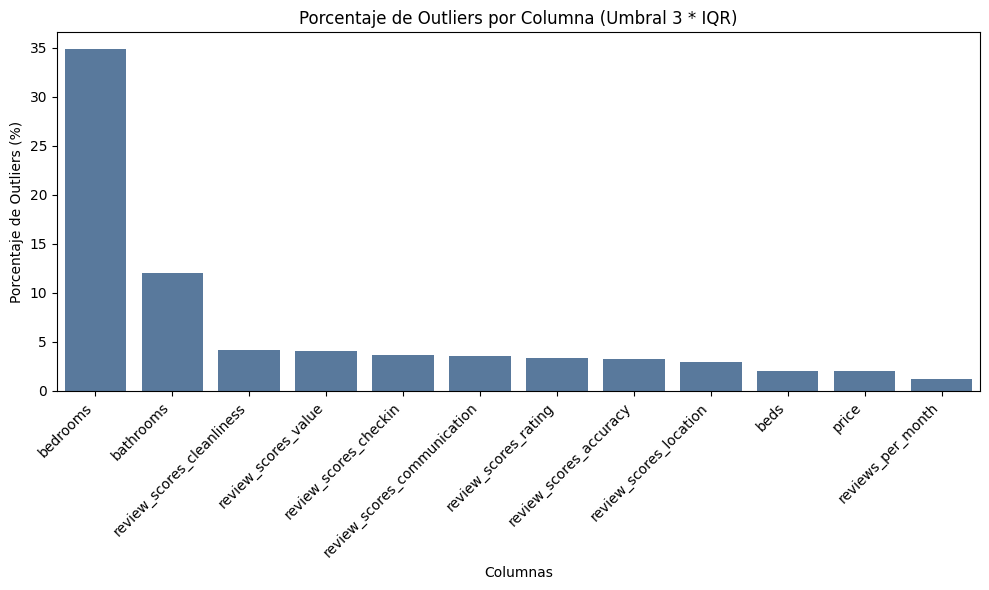


Columnas con outliers severos (IQR*3) a imputar: ['beds', 'bathrooms', 'bedrooms', 'price']


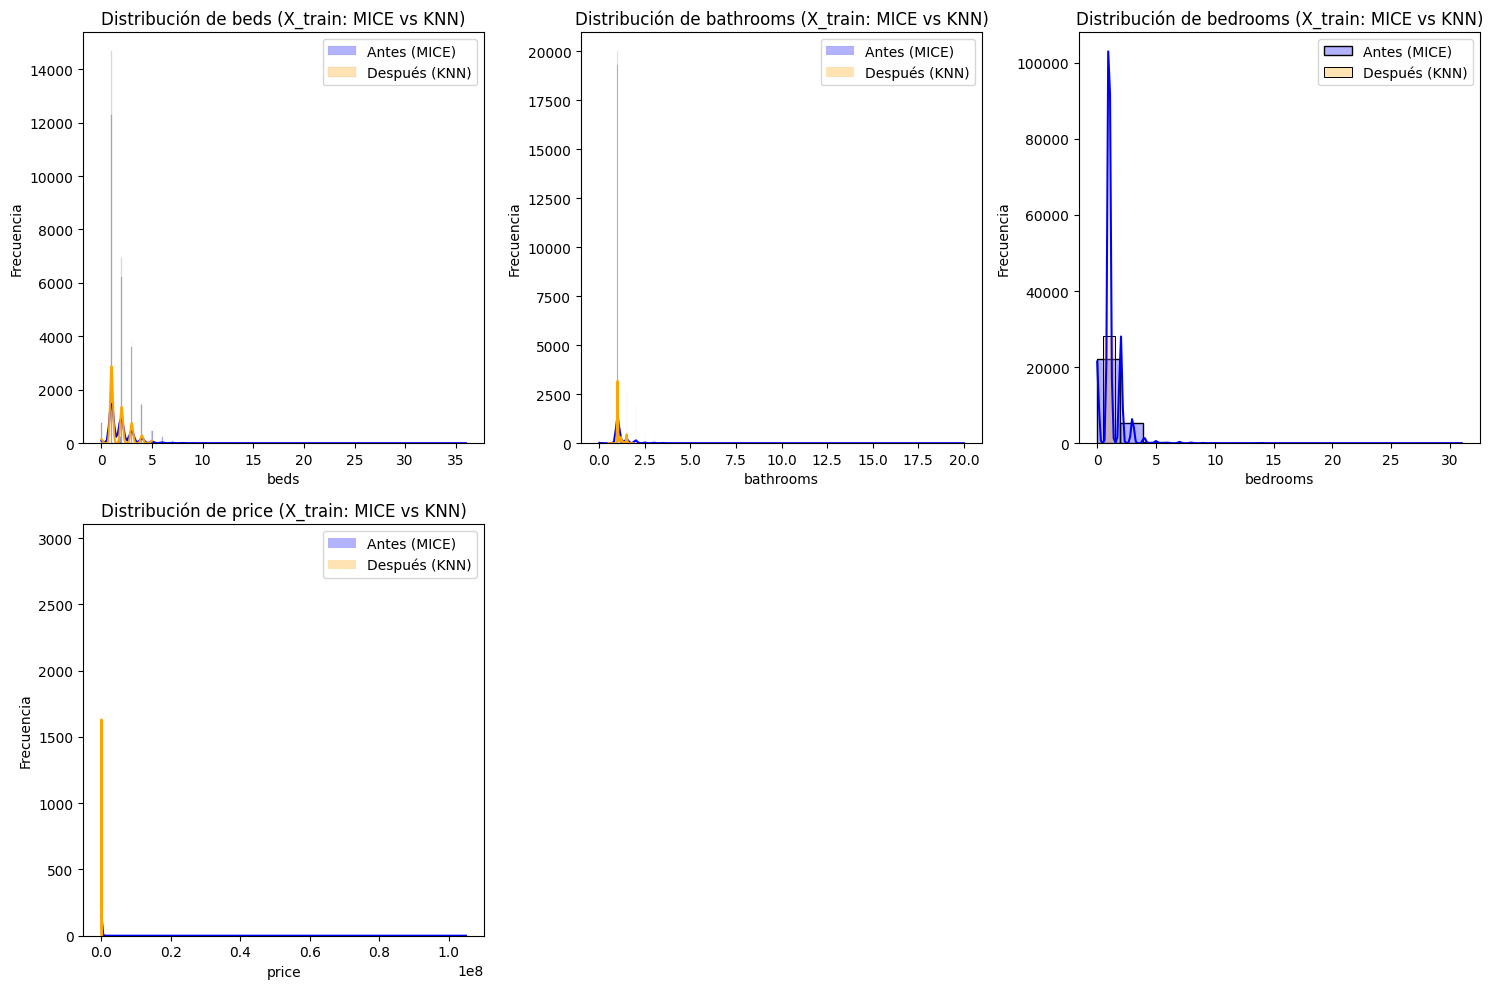

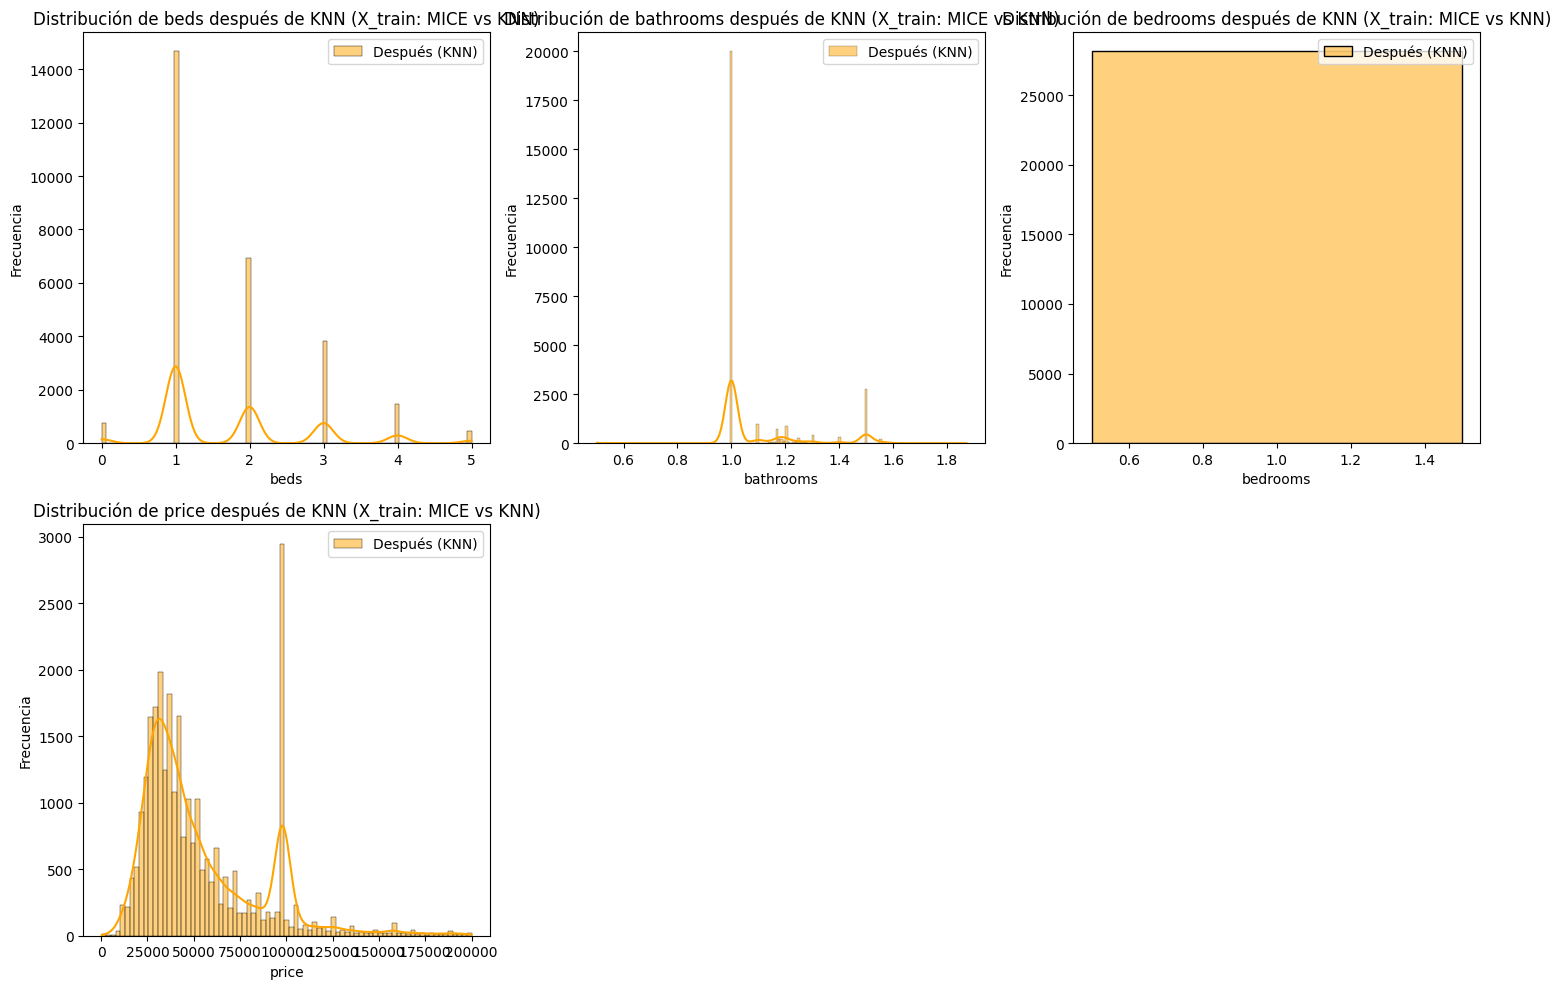

In [139]:
from sklearn.impute import KNNImputer
# Detectar outliers en X_train_imputed
resultados_outliers = detectar_outliers(X_train_imputed)

# Filtrar columnas con outliers para imputar
outliers_severos = ['beds', 'bathrooms', 'bedrooms', 'price']
print("\nColumnas con outliers severos (IQR*3) a imputar:", outliers_severos)

# Guardar df originales para comparar
X_train_imputed_original = X_train_imputed.copy()
X_test_imputed_original = X_test_imputed.copy()

# Crear máscaras para identificar outliers (IQR*3) en X_train_imputed y X_test_imputed
mascaras_train = {}
mascaras_test = {}
for col in outliers_severos:
    Q1 = X_train_imputed[col].quantile(0.25)
    Q3 = X_train_imputed[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR
    
    # Máscaras para identificar outliers
    mascaras_train[col] = (X_train_imputed[col] < limite_inferior) | (X_train_imputed[col] > limite_superior)
    mascaras_test[col] = (X_test_imputed[col] < limite_inferior) | (X_test_imputed[col] > limite_superior)

# Copiar DataFrames para no modificar los originales
X_train_imputed_knn = X_train_imputed.copy()
X_test_imputed_knn = X_test_imputed.copy()

# Convertir outliers a NaN para imputarlos
for col in outliers_severos:
    X_train_imputed_knn.loc[mascaras_train[col], col] = np.nan
    X_test_imputed_knn.loc[mascaras_test[col], col] = np.nan

# Imputar con KNN
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform')
X_train_imputed_knn_array = imputer_knn.fit_transform(X_train_imputed_knn[columnas_con_faltantes])
X_test_imputed_knn_array = imputer_knn.transform(X_test_imputed_knn[columnas_con_faltantes])

# Convertir los resultados de nuevo a DataFrames
X_train_imputed_knn = pd.DataFrame(X_train_imputed_knn_array, columns=columnas_con_faltantes, index=X_train_imputed.index)
X_test_imputed_knn = pd.DataFrame(X_test_imputed_knn_array, columns=columnas_con_faltantes, index=X_test_imputed.index)

# Reemplazar en los DataFrames originales solo las columnas imputadas
X_train_imputed[columnas_con_faltantes] = X_train_imputed_knn
X_test_imputed[columnas_con_faltantes] = X_test_imputed_knn

# Graficar distribuciones antes y después de la imputación KNN para X_train
def plot_distributions(df_before, df_after, columns, title_suffix):
    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols

    # Primera figura: Comparación antes (MICE) y después (KNN)
    plt.figure(figsize=(15, 5 * n_rows))
    for i, col in enumerate(columns):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df_before[col], kde=True, color='blue', alpha=0.3, label='Antes (MICE)')
        sns.histplot(df_after[col], kde=True, color='orange', alpha=0.3, label='Después (KNN)')
        plt.title(f'Distribución de {col} {title_suffix}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.legend()
    plt.tight_layout()
    plt.show()

    # Segunda figura: Solo después (KNN)
    plt.figure(figsize=(15, 5 * n_rows))
    for i, col in enumerate(columns):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df_after[col], kde=True, color='orange', alpha=0.5, label='Después (KNN)')
        plt.title(f'Distribución de {col} después de KNN {title_suffix}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.legend()
    plt.tight_layout()
    plt.show()

#Convertimos variables discretas a int
X_train_imputed_knn['beds'] = X_train_imputed_knn['beds'].astype(int)
X_train_imputed_knn['bedrooms'] = X_train_imputed_knn['bedrooms'].astype(int)


X_test_imputed_knn['beds'] = X_test_imputed_knn['beds'].astype(int)
X_test_imputed_knn['bedrooms'] = X_test_imputed_knn['bedrooms'].astype(int)

# Graficar distribuciones para columnas con outliers imputados
plot_distributions(X_train_imputed_original, X_train_imputed_knn, outliers_severos, '(X_train: MICE vs KNN)')

In [ ]:


df_listings_details_interes['precio_habitacion'] = df_listings_details_interes['price'] / df_listings_details_interes['bedrooms']
df_listings_details_interes['precio_cama'] = df_listings_details_interes['price'] / df_listings_details_interes['beds']
df_listings_details_interes['precio_baño'] = df_listings_details_interes['price'] / df_listings_details_interes['bathrooms']